# DeepGaze III Human Likeliness Evaluation

This project evaluates the behavior of the DeepGaze III model by comparing its saliency predictions with fixation maps generated from real user eye-tracking data. The evaluation uses two metrics:

<b>1. Fidelity (empirical):</b> How similar the model’s heatmaps are to aggregated human heatmaps.
<br>
<b>2. Fixation Frequency Similarity:</b> How similar the number and distribution of fixation clusters are between the model and humans.

The DeepGaze saliency map code is adapted from <i>Assignment 2B: Saliency Editing</i>.

#### Sources
1. Kümmerer, M., Bethge, M., & Wallis, T. S. (2022). DeepGaze III: Modeling free-viewing human scanpaths with deep learning. Journal of Vision, 22(5), 7-7. 
2. Papoutsaki, A., Sangkloy, P., Laskey, J., Daskalova, N., Huang, J., & Hays, J. (2016).
WebGazer: Scalable Webcam Eye Tracking Using User Interactions.
Proceedings of the 25th International Joint Conference on Artificial Intelligence (IJCAI), 3839–3845. AAAI Press.

### Objectives

The primary objective of this evaluation is to measure how closely the DeepGaze III model reproduces human visual attention when viewing static images. Although DeepGaze III has been shown to perform strongly on standard saliency benchmarks, validating its behavior on a set of photographs helps determine whether its predictions generalize beyond the training datasets. By comparing its saliency maps against heatmaps generated from real user gaze data, this study aims to assess the ability of DeepGaze at capturing human-like patterns of attention. 

A second objective is to quantify this comparison using two complementary dimensions: <b>fidelity</b> and <b>fixation frequency</b>. Fidelity focuses on the spatial similarity between DeepGaze predictions and human attention distributions, using KL divergence, correlation, and SSIM. These measures evaluate whether the model places attention in the same locations and with similar intensities as humans. Fixation frequency examines whether the model reproduces the natural temporal variability of human scanpaths. 

Comparing predictions to user-collected data allows the experiment to reveal systematic patterns where DeepGaze behaves differently from real human observers. These insights can inform future improvements in both modeling and data collection approaches, and they provide practical implications for using saliency models in design oriented tasks such as UI evaluation and user experience optimization.

In [ ]:
!python3 setup.py install

In [ ]:
!pip install torch scipy imageio opencv-python matplotlib torchvision

In [ ]:
import cv2
import deepgaze_pytorch
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

from imageio import imread
from scipy.ndimage import gaussian_filter, zoom
from scipy.stats import entropy
from scipy.special import logsumexp
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.metrics import structural_similarity as ssim

#### Step 1. Generate DeepGaze Model Saliency Maps

This step reuses the core code from Assignment 2B, with an additional component for collecting a fixation frequency map that records the number of fixations DeepGaze predicts for each image. This will be used as part of the model evaluation.

In [ ]:
# ------- Environment variables and model parameters -------

IMG_DIR = "images/"
USER_DATA_DIR = "user_data/"
DG_SALIENCY_DIR = "deepgaze_outputs/"
USER_SALIENCY_DIR = "user_outputs/"

num_scanpath_points = 10

freq_results = {}
deepgaze_freq_key = "deepgaze_fix_count"

# -------------------- Helper functions --------------------

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Create the circular mask for modeling inhibition of return
def create_circular_mask(h, w, fixations_x, fixations_y, radius):
    mask = torch.zeros(h, w)
    Y, X = np.ogrid[:h, :w]
    for i in range(len(fixations_x)):
        dist = np.sqrt((X - fixations_x[i])**2 + (Y - fixations_y[i])**2)
        mask = torch.maximum(mask, torch.from_numpy(dist <= radius))
    return 1 - mask

# the fixations parameters indicates the number of previous fixations to take into account
# to compute the probability of the next fixations
# it is set to 1 at the first recursive step
def prediction(image, fixations_x, fixations_y, centerbias, fixations, mask):

    # location of previous scanpath fixations in x and y (pixel coordinates), starting with the initial fixation on the image.
    fixation_history_x = np.array(fixations_x)
    fixation_history_y = np.array(fixations_y)

    model = deepgaze_pytorch.DeepGazeIII(fixations, pretrained=True)

    image_tensor = torch.tensor([image.transpose(2, 0, 1)])
    centerbias_tensor = torch.tensor([centerbias])
    x_hist_tensor = torch.tensor([fixation_history_x[model.included_fixations]])
    y_hist_tensor = torch.tensor([fixation_history_y[model.included_fixations]])

    log_density_prediction = (100 + model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)) \
                                * mask.unsqueeze(0).unsqueeze(0)

    # Find the brightest pixel in the probability map
    brightest_pixel = (log_density_prediction==torch.max(log_density_prediction)).nonzero()[0].detach().cpu().numpy()

    return brightest_pixel

images = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")])

In [ ]:
deepgaze_heatmaps = {}
for path in images:
    image = imread(IMG_DIR + path)
    # image = cv2.resize(image, (256, 256))

    # load precomputed centerbias log density (from MIT1003) over a 400x1024 image
    # you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
    # alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
    centerbias_template = np.load('assets/centerbias_mit1003.npy')
    
    # rescale to match image size
    centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
    
    # renormalize log density
    centerbias -= logsumexp(centerbias)

    # Fixation history set as the center of the image
    height = image.shape[0] // 2
    width = image.shape[1] // 2

    # Result scanpath
    fixations_x = [width]
    fixations_y = [height]
    fixations = 1

    # Recursively predict the fixations until we have predicted 13 of them
    while len(fixations_x) <= num_scanpath_points:

        # Inhibition of Return (IOB)
        radius = int(0.2 * min(image.shape[1], image.shape[0]))
        mask = create_circular_mask(image.shape[0], image.shape[1], fixations_x, fixations_y, radius)
        brightest_pixel = prediction(image * mask.unsqueeze(2).numpy().astype('uint8'), fixations_x, fixations_y, centerbias, fixations, mask)

        # add the newly predicted pixel to the history of fixations
        fixations_x.append(brightest_pixel[3])
        fixations_y.append(brightest_pixel[2])

        # For each new fixation point we increase the fixations parameter by 1 until it hits 4
        if fixations <= 3:
            fixations += 1
    
    deepgaze_heatmaps[path] = make_heatmap_from_fixations(fixations_x, fixations_y, image.shape[1], image.shape[0], sigma=30)

    # append to frequency map for later analysis
    freq_results[path][deepgaze_freq_key] = len(fixations_x)

    # Plot and save the result as a png file
    print("plot")
    plt.figure()
    plt.matshow(image, fignum=0)
    plt.plot(fixations_x, fixations_y, 'o-', color='red')
    plt.scatter(fixations_x[-1], fixations_y[-1], 40, color='green', zorder=100)
    plt.axis('off')
    
    os.makedirs(DG_SALIENCY_DIR, exist_ok=True)
    plt.savefig(DG_SALIENCY_DIR + path.replace(".jpg", "_saliency.png"), transparent=True)
    plt.close()


#### Step 2. Generate Human Fixation Maps Using User Data

To gather user eye-tracking data, I published an experiment webpage using WebGazer.js:
https://urverkmi.github.io/eyetrack-model-eval/index.html

The webpage performs calibration, image presentation, webcam gaze integration, as well as per-session data download.

Using this data, I generated per-user heatmaps with Gaussian smoothing to reduce jitter. I also generated fixation visualizations similar to those produced in Assignment 2B. Human fixation frequencies were recorded in the same data structure as the DeepGaze results.

In [ ]:
# Load user output data into a map by images to be cleaned and processed.
gaze_by_user = {}
gaze_data = {}
for f in os.listdir(USER_DATA_DIR):
    if f.endswith(".json"):
        with open(USER_DATA_DIR + f) as file:
            gaze_data[f] = json.load(file)
            gaze_by_user[f] = {}

    for img in images:
        gaze_by_user[f][img] = [(d["x"], d["y"]) for d in gaze_data[f] if d["img"] == IMG_DIR + img]

for k, v in gaze_by_user.items():
    print(k, len(v), "samples")

In [ ]:

def plot_fixations(xs, ys, quantile=0.2, n_samples=50, min_bandwidth = 20):
    coords = np.column_stack([xs, ys])
    
    if len(coords) < 2:
        return coords.tolist()

    # Estimate bandwidth dynamically
    bandwidth = estimate_bandwidth(coords, quantile=quantile, n_samples=n_samples)

    if bandwidth is None or bandwidth <= 0:
        bandwidth = min_bandwidth  # fallback

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(coords)
    
    fixation_centers = ms.cluster_centers_

    # Plot resulting fixations on the image
    plt.figure()
    plt.matshow(image)
    plt.axis('off')

    for (fx, fy) in fixation_centers:
        plt.scatter(fx, fy, s=80, color='red')
    if len(fixation_centers) > 0:
        fx, fy = fixation_centers[-1]
        plt.scatter(fx, fy, s=120, color='green')

    os.makedirs(USER_SALIENCY_DIR, exist_ok=True)
    plt.savefig(USER_SALIENCY_DIR + img_name.replace(".jpg", "_fixations.png"), transparent=True)
    plt.close()


def make_heatmap(points, width, height, img_name, user, sigma=30):
    # Build raw heatmap
    heatmap = np.zeros((height, width), dtype=np.float32)
    xs, ys = [], []

    for (x, y) in points:
        if 0 <= x < width and 0 <= y < height:
            heatmap[int(y), int(x)] += 1.0
            xs.append(x)
            ys.append(y)

    # append to frequency map for later analysis
    freq_results[img_name] = {user: len(xs)}
    
    # smoothing
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    if heatmap.sum() > 0:
        heatmap /= heatmap.sum()
    
    # detect and plot fixations
    plot_fixations(xs, ys)

    return heatmap

human_heatmaps = {}
for img_name in images:
    image = load_image(IMG_DIR + img_name)
    h, w = image.shape[:2]
    pts = []
    for user in gaze_by_user.keys():
        pts.extend(gaze_by_user[user][img_name])
        human_heatmaps[img_name] = make_heatmap(pts, w, h, img_name, user)
    


In [54]:
def make_heatmap_from_fixations(xs, ys, width, height, sigma=30):
    heatmap = np.zeros((height, width), dtype=np.float32)

    for x, y in zip(xs, ys):
        if 0 <= x < width and 0 <= y < height:
            heatmap[int(y), int(x)] += 1.0

    # smooth
    heatmap = gaussian_filter(heatmap, sigma=sigma)

    # normalize
    if heatmap.sum() > 0:
        heatmap /= heatmap.sum()

    return heatmap

#### Step 3. Model Evaluation

The evaluation examines the human-likeness of DeepGaze III across two dimensions:

<b>1. Fidelity:</b> KL Divergence, Pearson Correlation Coefficient, and SSIM.
<br>
<b>2. Fixation Frequency Similarity:</b> Comparison of fixation cluster counts between DeepGaze and human users.

#### Step 3.1 Fidelity
Fidelity describes how closely DeepGaze’s heatmaps match aggregated human heatmaps. The computed metrics (KL, Correlation, SSIM) are saved into <code>metrics.csv</code>. Visual comparison figures include heatmap overlays and heatmap difference maps.

In [130]:
def kl_divergence(P, Q, eps=1e-12):
    P = P.flatten() + eps
    Q = Q.flatten() + eps
    return entropy(P, Q)

def correlation(P, Q):
    return np.corrcoef(P.flatten(), Q.flatten())[0,1]

def ssim_metric(P, Q):
    return ssim(P, Q, data_range=Q.max() - Q.min())

results = {}

for img in images:
    P = human_heatmaps[img]
    Q = deepgaze_heatmaps[img]

    assert isinstance(P, np.ndarray) and P.ndim == 2
    assert isinstance(Q, np.ndarray) and Q.ndim == 2
    assert P.shape == Q.shape

    if len(P) > 0 and len(Q) > 0:
        results[img] = {
            "KL": kl_divergence(P, Q),
            "Corr": correlation(P, Q),
            "SSIM": ssim_metric(P, Q)
        }

df = pd.DataFrame(results).T
df.to_csv("metrics.csv")


#### Heatmap Comparison and Observed Limitations

The code below generates a visualization of the differences between the human and DeepGaze heatmaps. From these plots, we can clearly identify several limitations in the experiment setup.

<ol> <li> Limitations of WebGazer.js for <b>non-interactive image viewing</b>.<br> The WebGazer script is not trained to capture real user fixation behavior with high precision. When tested in its default configuration, the red prediction dot rarely follows my actual gaze. This is because WebGazer was originally designed for interactive web environments and relies heavily on <i>mouse movement</i> for continuous self-calibration. <br>I added a dedicated calibration module to improve accuracy, but the tracker still fails to capture the full fidelity of a user’s gaze, especially when viewing static images. </li> <br> <li> DeepGaze III <b>does not vary attention strength</b> across fixations.<br> DeepGaze provides a reasonable <i>scanpath</i>, but when converted into a heatmap, its fixations all have similar intensity. This means the model does not distinguish between locations that are highly attention-grabbing and those that are only weakly attended. <br>In contrast, human users naturally vary fixation durations and revisit important regions more often, producing heatmaps with a richer distribution of attentional weight. </li> </ol>

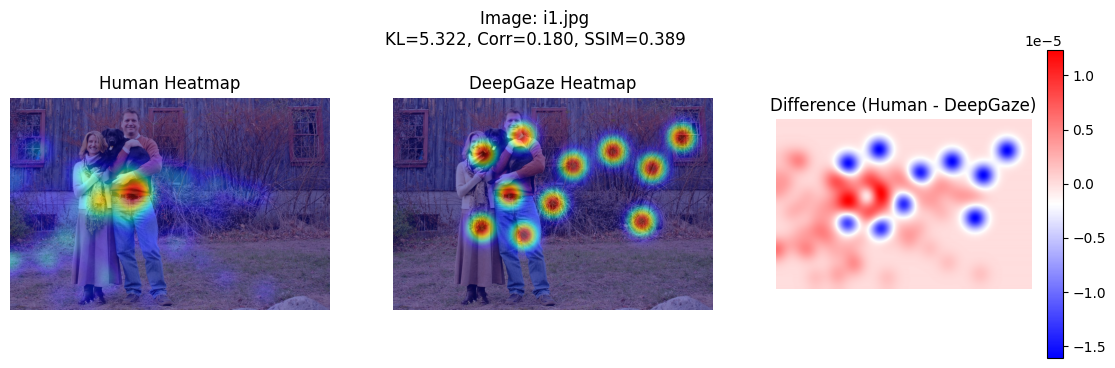

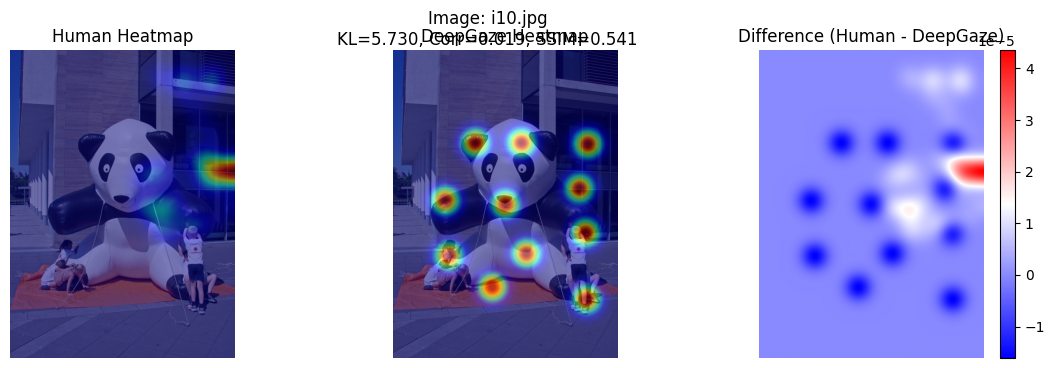

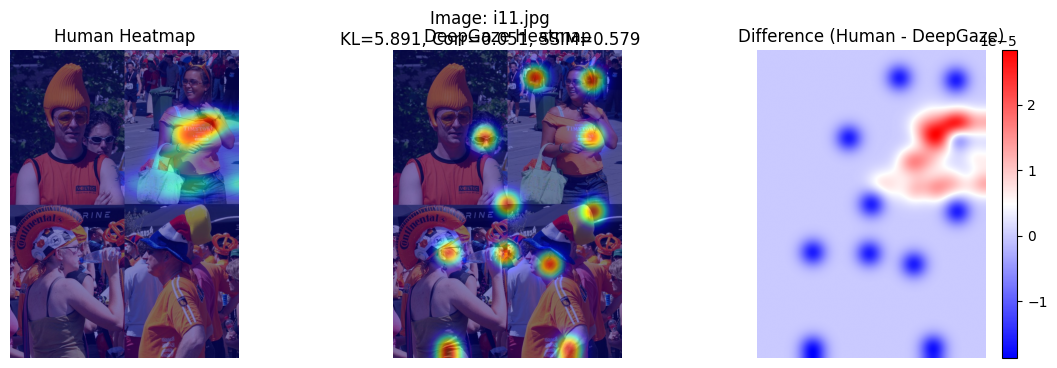

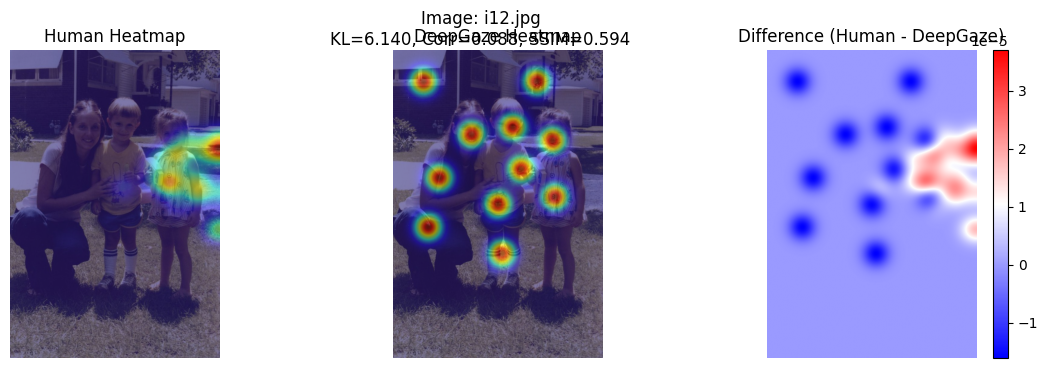

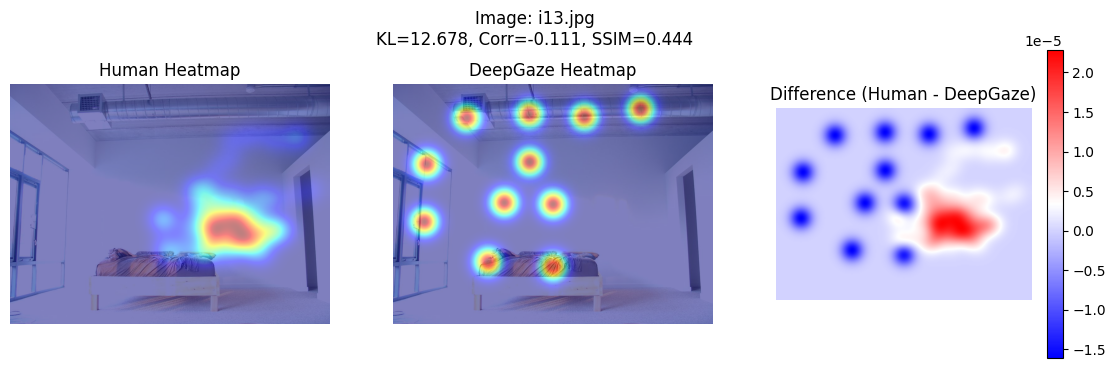

In [153]:
show_counter = 0
for img in images:
    if show_counter < 5:
        I = load_image(IMG_DIR + img)
        H = human_heatmaps[img]
        D = deepgaze_heatmaps[img]
        
        plt.figure(figsize=(14,4))
        plt.suptitle(f"Image: {img}\nKL={results[img]['KL']:.3f}, Corr={results[img]['Corr']:.3f}, SSIM={results[img]['SSIM']:.3f}")

        plt.subplot(1,3,1)
        plt.title("Human Heatmap")
        plt.imshow(I)
        plt.imshow(H, cmap='jet', alpha=0.5)
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("DeepGaze Heatmap")
        plt.imshow(I)
        plt.imshow(D, cmap='jet', alpha=0.5)
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title("Difference (Human - DeepGaze)")
        diff = H - D
        plt.imshow(diff, cmap='bwr')
        plt.colorbar()
        plt.axis('off')

        plt.show()
        show_counter += 1

#### Step 3.2 Fixation Frequency Similarity

Fixation frequency evaluates whether the model produces a similar number of fixation clusters to human users.

Since DeepGaze generates a <b>fixed</b> number of fixations for every image, it does not adjust the number of fixations based on image complexity. Human users naturally exhibit variable fixation counts: more for visually dense images and fewer for simple ones. This highlights a limitation of the model.

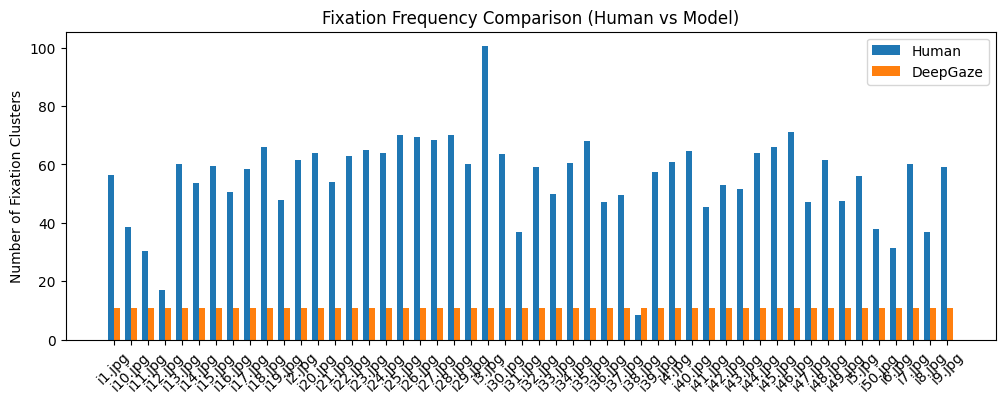

In [149]:
def count_fixations(xs, ys, eps_ratio=0.03, min_samples=2):
    coords = np.column_stack([xs, ys])
    eps = eps_ratio * max(coords[:,0].ptp(), coords[:,1].ptp())
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_
    return len(set(labels) - {-1})  # ignore noise

# labels = images
human_counts = np.zeros(len(images))
for i, image in enumerate(images):
    for user in freq_results[image]:
        if user != deepgaze_freq_key:
            human_counts[i] += freq_results[image][user]
human_counts /= len(os.listdir(USER_DATA_DIR))
deepgaze_counts = [freq_results[image][deepgaze_freq_key] for image in images]

x = np.arange(len(images))
width = 0.35

plt.figure(figsize=(12,4))
plt.bar(x - width/2, human_counts, width, label="Human")
plt.bar(x + width/2, deepgaze_counts, width, label="DeepGaze")

plt.xticks(x, images, rotation=45)
plt.ylabel("Number of Fixation Clusters")
plt.title("Fixation Frequency Comparison (Human vs Model)")
plt.legend()
plt.show()


### Conclusion

Overall, this evaluation highlights both the promise and the current limitations of DeepGaze III when applied to real-world user attention modeling. Although the model demonstrates the ability to generate coherent scanpaths, when subjected to quantitative comparison, the discrepancies between human data and model predictions become obvious. These differences suggest that while DeepGaze effectively captures where humans might look in a broad sense, it does not fully reproduce the distribution of attention that naturally emerges from human viewing behavior.

At the same time, the evaluation process underscores challenges in the data collection pipeline. The WebGazer-based tracking setup introduces inaccuracies that inevitably affected the plausibility of human heatmaps even with an additional calibration module. Therefore, the observed gap between the model and human data may have been amplified from imperfect measurements rather than model shortcomings alone. 

Despite these constraints, the overall comparison still reveals meaningful insights: DeepGaze’s fixed-length scanpaths and uniform fixation weights limit its ability to reflect the true patterns that real users exhibit. Moving forward, improving data quality and exploring models with adaptive fixation behavior would allow for more precise assessments.